# Figures / analysis for flat slab paper

In [1]:
%pylab inline
import numpy as np

import seaborn as sns
import glob2
import pandas as pd
import h5py
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
import natsort
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import CubicSpline
import numpy as np
import pint

u = pint.UnitRegistry()

Populating the interactive namespace from numpy and matplotlib


In [2]:
#ls /workspace2

In [3]:
#dimensionalisation factors

velScale = 3.4482758620689656e-13*(3600*24*365)*100.  #cm/y
timeScale = 8.41e+18/(1e6*3600*24*365)
lengthScale = 2900. #km
stressScale =  11.890606*1e-6   #to MPa

## Functions Required

In [4]:
def listify_data(unique_string, path):
    glob_str = path + '*' + unique_string + '*'
    files = natsort.natsort(glob2.glob(glob_str))
    #print(glob_str)
    #return files
    
    dataList = []
    for f in files:
        with h5py.File(f,'r') as hf:
            data = hf.get('data')
            dataList.append(np.array(data))
    return dataList


def get_along_strike(pts):
    dxs = np.diff(pts[:,0])
    dys = np.diff(pts[:,1])
    ds = np.sqrt(dxs**2 + dys**2)
    
    #pad the first point
    return np.append(ds[0], ds) , np.cumsum(np.append([0.], ds)) #front and back pad these arrays


def curvature_splines(x, y):
    """Calculate the signed curvature of a 2D curve at each point
    using interpolating splines.
    Parameters
    ----------
    x,y: numpy.array(dtype=float) shape (n_points, )
    """

    fx = CubicSpline(x, x)
    fy = CubicSpline(x, y)
    #print(np.sqrt(std))

    #x1 = fx.derivative(1)(x)
    #x2 = fx.derivative(2)(x)
    y1 = fy.derivative(1)(x)
    y2 = fy.derivative(2)(x)
    #curvature = (x1* y2 - y1* x2) / np.power(x1** 2 + y1** 2, 1.5)
    curvature = (y2) / np.power(1 + y1** 2, 1.5)

    return curvature, fx, fy, y1

## Setup filter

In [5]:
import scipy.signal as signal
N  = 2    # Filter order
# Cutoff frequency `Wn` is normalized from 0 to 1, 
#where 1 is the Nyquist frequency, pi radians/sample.

#Wn = 0.19 #
#Wn1 = 0.025 #

Wn = 0.26 #
Wn1 = 0.101 #

B, A = signal.butter(N, Wn, output='ba')
B1, A1 = signal.butter(N, Wn1, output='ba')



In [ ]:
i = 87               #timestep to analyse


## Dataframe with plate boundary location

In [38]:
def get_dataframe():
    #file_ = '../models/results/A/20/values/tect_model_data.npz'
    file_ = '../models/results/B/16/values/tect_model_data.npz'
    out = np.load(file_)
    d = dict(out)
    df = pd.DataFrame.from_dict(d)
    return df 

df = get_dataframe()

In [42]:
trenchLoc = (df['(2, 3)'].iloc[i] - 30./lengthScale)*lengthScale
print(trenchLoc)

-510.036509971


## Load data

In [6]:
#loads slab midplane points, all timesteps

mppoints = listify_data('midplane**', '../models/results/{}/{}/**/'.format('B', 16))

In [7]:
depthlimit = 1. - (250/2900.)   #depth cutoff (avoids dealing with overturned slab)

In [8]:
#order the data 

indexes = np.argsort(mppoints[i][:,0])
NP = 4    #only us every Nth point
sortedData = mppoints[i].copy()[indexes]
sortedData = sortedData[sortedData[:,1] > depthlimit] #remove deeper points
sortedData = sortedData[sortedData[:,0] > -0.5] #remove points away from the trench
sortedData = sortedData[::NP,:]
ds, ds_cum = get_along_strike(sortedData)
dsMean = ds.mean()


In [9]:
# Second, apply the filter
print(dsMean*lengthScale)
print((1./Wn)*(dsMean*lengthScale))  #wavelength of filter 1
print((1./Wn1)*(dsMean*lengthScale)) #wavelength of filter 2

2.56337263246
9.85912550945
25.379927054


# Estimate the curvature, curvature gradient

In [10]:
fy = CubicSpline(sortedData[:,0], sortedData[:,1])

y1_ = fy.derivative(1)(sortedData[:,0])
y2_ = fy.derivative(2)(sortedData[:,0])
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

c_F = signal.filtfilt(B,A, c_)

dxMean = ds.min()*1

cx_0 = np.gradient(c_, dxMean)
cx_F= signal.filtfilt(B,A, cx_0)
cx_F1= signal.filtfilt(B1,A1, cx_0)

## Plot the curvatire gradient, check filters

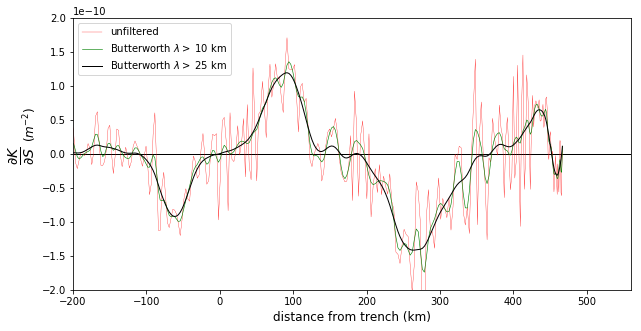

In [11]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_0*(1./2900e3**2),c = 'r', label='unfiltered', lw = 0.3)
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F*(1./2900e3**2), 
        c = 'g', lw = 0.6, label=r'Butterworth $\lambda >$ 10 km')
ax.plot(sortedData[::1,0]*2900 - trenchLoc, cx_F1*(1./2900e3**2), 
        c = 'k', lw = 1, label=r'Butterworth $\lambda >$ 25 km')


ax.set_xlabel('distance from trench (km)', size = 12)
ax.set_ylabel(r'$\frac{\partial{K}}{\partial{S}}$ ', size = 20)


ax.hlines(0, -200, 600, lw=1)
#ax.plot(sortedData[::n,0], cxF)
ax.set_ylim(-2e-10, 2e-10)
ax.set_xlim(-200, 560)
ax.legend(loc = 2)

ax.text(-270, 0.5e-10, r'($m^{-2}$)', size = 12, rotation=90)

In [12]:
#f.savefig('filtering.png', dpi=400, bbox_inches='tight')

## Save midplane gradient data

In [13]:
midPlaneCurv = np.column_stack( ( 2900.*sortedData[:,0], c_F *(1./2900)  ))
midPlaneCurvGrad = np.column_stack( ( 2900.*sortedData[:,0], cx_F1*(1./2900**2) ))
dimData = np.column_stack(( sortedData[:,0]*2900.0, (1. - sortedData[:,1])*2900.0 ))

#np.savetxt('midPlane.csv', dimData, delimiter=',')
#np.savetxt('curv.csv', midPlaneCurv , delimiter=',')
#np.savetxt('curvGrad.csv', midPlaneCurvGrad, delimiter=',')


## Load the subduction interface data


In [14]:
## Get / save interface 

interfaceOffsetKm = 7.
ifpoints = listify_data('interface**', '../models/results/{}/{}/**/'.format('B', 16))

indexes = np.argsort(ifpoints[i][:,0])
intData = ifpoints[i].copy()[indexes]

dimIntData0 = np.column_stack((2900.*intData[:,0], 
                            2900.*(1. - intData[:,1]) - 0. ))
dimIntData = np.column_stack((2900.*intData[:,0], 
                           2900.*(1. - intData[:,1]) - interfaceOffsetKm))




#save dimensional interface data
#np.savetxt('slabTop.csv', dimIntData, delimiter=',')

## Set UW mesh, and load fields

In [15]:
import os

import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer


In [16]:
yres = 192
xres = int(yres  * 6)
elementType = 'Q1/dQ0'
#depth = 0.3448275862068966
depth = 0.43103448275862066
aspectRatio  = 4



halfWidth = 0.5*depth*aspectRatio 

minCoord_    = (-1.*halfWidth, 1. - depth) 
maxCoord_    = (halfWidth, 1.)

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType),
                                 elementRes  = (xres, yres), 
                                 minCoord    = minCoord_, 
                                 maxCoord    = maxCoord_) 

scalarField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
strainField   = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )


In [17]:
#mesh.reset() #call to reset mesh nodes to original locations
meshRefineFactor = 0.7
refineHoriz = True
refineVert = True


    
with mesh.deform_mesh():
    
    normXs = 2.*mesh.data[:,0]/(mesh.maxCoord[0] - mesh.minCoord[0])
    mesh.data[:,0] = mesh.data[:,0] * np.exp(meshRefineFactor*normXs**2) / np.exp(meshRefineFactor*1.0**2)    



with mesh.deform_mesh():
    
    mesh.data[:,1] = mesh.data[:,1] - 1.0

    normYs = -1.*mesh.data[:,1]/(mesh.maxCoord[1] - mesh.minCoord[1])
    mesh.data[:,1] = mesh.data[:,1] * np.exp(meshRefineFactor*normYs**2)/np.exp(meshRefineFactor*1.0**2)

    mesh.data[:,1] = mesh.data[:,1] + 1.0


In [18]:
#sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/sigSS**.h5'))
sigFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/sigSS**.h5'))
sfile = sigFiles[i]

#tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/A/6/temp**.h5'))
tempFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/temp**.h5'))
tfile = tempFiles[i]

#strain rate 
#eFiles = natsort.natsort(glob2.glob('/workspace2/flat_slab/B/16/eSS**.h5'))
#efile = eFiles[i]
#efile

In [19]:
scalarField.load(sfile)
tempField.load(tfile)
#strainField.load(efile)

## Setup uniform Numpy grid to interpolate data 

In [20]:
dm = 10/2900.               #grid spacing numoy
inset = 0.999999999999     #build teh grid just inside the undeworld domain to avoid out of bounds errors
inset_ = 1/inset

meshxs = np.arange(mesh.minCoord[0]*inset, mesh.maxCoord[0]*inset , dm )
meshys = np.arange(mesh.minCoord[1]*inset_, mesh.maxCoord[1]*inset , dm )
xv, yv = np.meshgrid(meshxs, meshys )
#uw just wants an Mx2 array
coords = np.array(zip(xv.flatten(), yv.flatten()))

In [21]:
#interpolate data into our numpy arrays
#these are 1-D

stressdata = scalarField.evaluate(coords[:, :])[:,0] 
tempdata = tempField.evaluate(coords[:, :])[:,0]
#straindata = strainField.evaluate(coords[:, :])[:,0]


In [22]:
#Now create teh 2D arrays and dimensionalaze
stress = np.zeros(xv.shape) 
stress[:] = np.flipud(stressdata.reshape((xv.shape)))*stressScale

temp = np.zeros(xv.shape) 
temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
stress[temp > 1270] = np.nan


#strain = np.zeros(xv.shape) 
#strain[:] = np.flipud(straindata.reshape((xv.shape)))
#strain = np.clip(strain, -5000, 5000)
#strain[temp > 1270] = np.nan

In [23]:
#save the numpy arrays

#np.savetxt('temp.csv', temp, fmt='%.2f', delimiter=',')
#np.savetxt('stress.csv', stress, fmt='%.2f', delimiter=',')
#np.savetxt('xcoords.csv', xv, fmt='%.2f', delimiter=',')
#np.savetxt('ycoords.csv', yv, fmt='%.2f', delimiter=',')


#testtemp = np.loadtxt('temp.csv', delimiter=',')
#testy = 
#plt.imshow(testtemp)

## Plot temperature

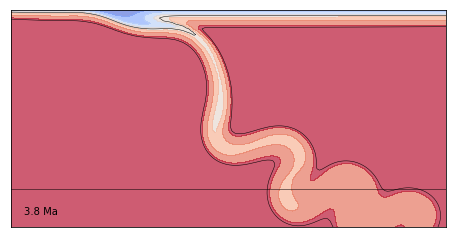

In [24]:
fig, ax = plt.subplots(figsize=(12, 4))
#ax.imshow(stress, cmap='coolwarm', vmax = 150, vmin = -150, 
#          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 1000, 0] )
times = [3.8, 7.7, 12.5, 17.3, 22.2, 30.1]
lf = ax.contourf(temp, cmap='coolwarm', vmax = 1300, vmin = 1, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], 
                alpha = 0.65,
                levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

ax.contour(temp, colors='k', levels=[ 700., 1250.], 
                 extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], linewidths = 0.5 )

ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

ax.set_xlim(-800, 800)
ax.set_ylim(800, 0)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])

ax.text(-750, 750,'{} Ma'.format(times[0]), size = 10)


In [39]:
#f.savefig('evolution.png', dpi=300, bbox_inches='tight')

## Plot resolved stress, curvature etc.

In [25]:
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

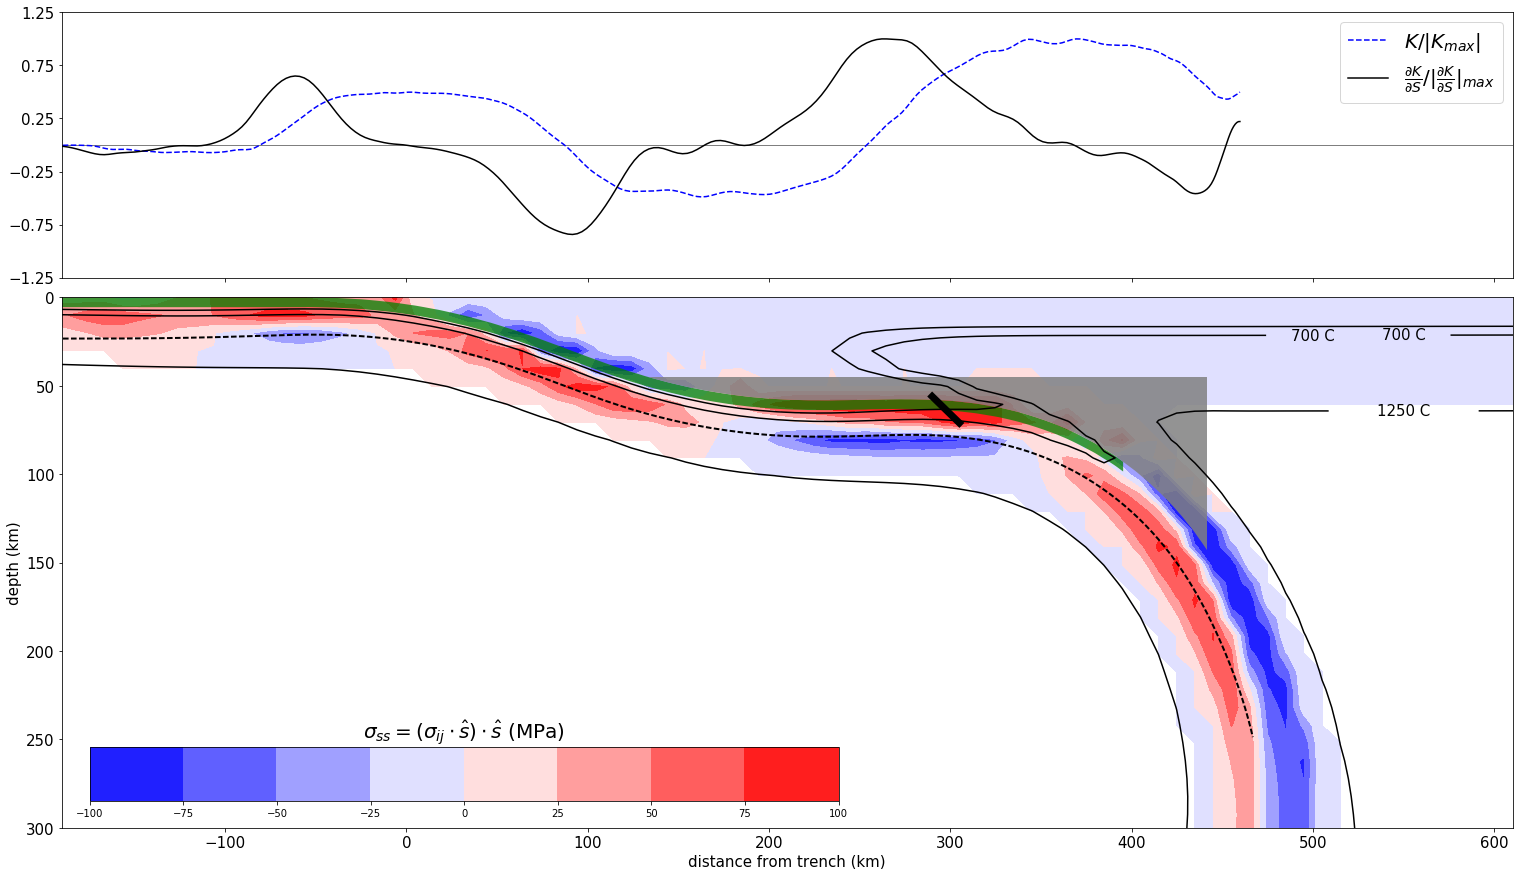

In [29]:
# plot it


fig = plt.figure(figsize=(26, 15)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2]) 
gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

########################


indexWedge = np.argmin(np.abs(dimIntData[:,1] - 45)) #this determines where the LVW intersects the subduction interface

ax0 = plt.subplot(gs[0])

#ax0.plot(2900.*sortedData[:-10],(y2/abs(y2.max()))[:-10] , c= 'k', ls = '--', 
#         label = r'$\frac{K_{,s}}{K_{,s_{max}}}$', lw = 2)

blok = -10
blok1 = 50
blok2 = -50

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*c_F[:blok ]/np.abs(c_F[blok1:blok2]).max() , 
         c = 'b',ls = '--', label = r'$K/\left|K_{max}\right|$' )

ax0.plot( 2900.*sortedData[::1,0][:blok ] - trenchLoc, -1.*cx_F1[:blok ]/np.abs(cx_F1[blok1:blok2]).max() ,  
         c = 'k', label = r'$ \frac{ \partial{K}  }{ \partial{S}} / \left|\frac{ \partial{K}  }{ \partial{S}}\right|_{max} $' )




ax0.hlines(0 , -700. -  trenchLoc, 100. - trenchLoc, linewidths = 0.5)
ax0.set_xlim(-700. - trenchLoc, 100. - trenchLoc)
ax0.set_ylim(-1.1, 1.1)
ax0.set_yticks(ax0.get_yticks()[::2])

ax0.tick_params(labelsize=15)



#ax0.ticklabel_format(style='sci',axis='y', scilimits=(0,0))

ax0.legend(fontsize = 20)

#ax0.set_yticklabels([])
ax0.set_xticklabels([])
#ax0.grid(False)

########################
ax1 = plt.subplot(gs[1])



cb = ax1.contourf(stress, cmap='bwr', vmax = 100, vmin = -100, 
          extent=[mesh.minCoord[0]*2900 - trenchLoc, mesh.maxCoord[0]*2900  - trenchLoc, 0, 1250] )



CS = ax1.contour(temp, colors='k', levels=[600,700., 1250.], 
                 extent=[mesh.minCoord[0]*2900 - trenchLoc, mesh.maxCoord[0]*2900 - trenchLoc, 0, 1250] )


cl = ax1.clabel(CS, fontsize=15, inline=1, fmt='%1.0f' + ' C', 
           manual=[(550,80),(550, 30), (500, 25)], inline_spacing=-15)

#this one is used for extracting the temperature contours. (trench offset not applied)
#CS2 = ax1.contour(temp, colors='k', levels=[700., 1250.], 
#                 extent=[mesh.minCoord[0]*2900 , mesh.maxCoord[0]*2900 , 0, 1250] )


ax1.plot(2900.*sortedData[:,0] - trenchLoc, 2900 - 2900.*sortedData[:,1], c= 'k', ls = '--', lw = 2)


#mask = dimData0[:,1] < 90.
mask = dimIntData0[:,1] < 100.

ax1.fill_between(dimIntData0[mask,0] - trenchLoc, dimIntData[mask,1] , dimIntData0[mask,1] - 1.5, facecolor='green', alpha=0.75)

ax1.fill_between(dimIntData[indexWedge:,0] - trenchLoc, 
                 dimIntData[indexWedge:,1], 45*np.ones(len(dimIntData[indexWedge:,1])), facecolor='gray', alpha=0.85) 



ax1.set_xlim(-700 - trenchLoc, 100 - trenchLoc)
ax1.set_ylim(300, 0)

ax1.set_ylabel('depth (km)', size = 15)
ax1.set_xlabel('distance from trench (km)', size = 15)
ax1.grid(False)
ax1.tick_params(labelsize=15)


# Now adding the colorbar
cbaxes = fig.add_axes([0.14, 0.15, 0.4, 0.05]) 
cb1 = colorbar(cb, cax = cbaxes, orientation="horizontal") 
cb1.set_label(r'$\sigma_{ss} =  (\sigma_{ij} \cdot \hat s)\cdot \hat s$ (MPa)', size= 20, labelpad=-100)


ax1.plot([290,305], [56,71], lw = 7, c='k')


In [741]:
#fig.savefig('stress_curv.png', dpi=250, bbox_inches='tight')

## Save contours

In [261]:
p = CS2.collections[0].get_paths()
pv = [path.vertices for path in p]
out = np.concatenate(pv) #already dimensionalized
#np.savetxt('700C_contour.csv', out , delimiter=',')

In [80]:
#fig, ax = plt.subplots(figsize=(20,2))
#ax.scatter(out[:,0] , out[:,1])

#ax.set_xlim(0, 700)
#ax.set_ylim(300, 0)
#ax.set_aspect('equal')

## Plot temp at multiple timesteps (can take a while)

In [ ]:
#np.arange(8, 56,8)

times = [19, 27]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0.05, hspace=0.025)

count = 0
for i in [67, 87]:
    tfile = tempFiles[i]
    tempField.load(tfile)
    tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    temp = np.zeros(xv.shape) 
    temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    ax.contourf(temp, cmap='coolwarm', vmax = 1400, vmin = 0, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], 
                alpha = 0.65, 
               levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

    ax.contour(temp, colors='k', levels=[700., 1250.], 
                     extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1250], linewidths = 0.5 )

    ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-800, 800)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-750, 770,'{} Myr'.format(times[count]), size = 10)
    count += 1

## Plate age at trench 

-698.4301633747034

In [59]:
times = np.linspace(0,35., 100)
vp =  np.linspace(9, 3., 100)
vr = 2.
plateLength = abs(df['(1, 2)'][i]*2900 - trenchLoc) - 30. #correction for MOR loc
ageAtFlat = df.timeAtSave.iloc[i]*timeScale

vp_r =  vp - vr #sp velocity on moving trench ref frame

vp *= 10 #factor of 10 converts from cm/y to km/myr
vp_r *= 10 

vgrad = (vp[-1] - vp[0])/times[-1]
int_1 = 0.5*vgrad* times**2 + vp[0]*times
int_2 = 0.5*vgrad* times**2 + vp_r[0]*times

distatT = int_2[np.argmin(np.abs(times - ageAtFlat))]
refDist = distatT - plateLength
ageSlab = ageAtFlat - times[np.argmin(np.abs(int_2 - refDist ))]

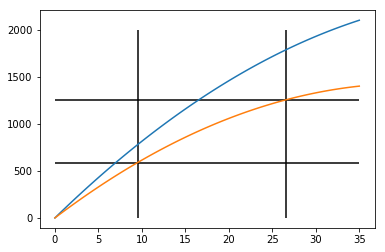

In [60]:
fig, ax = plt.subplots()
ax.plot(times, int_1)
ax.plot(times, int_2)
ax.hlines(refDist ,0, 35 )
ax.hlines(distatT ,0, 35 )

ax.vlines(ageAtFlat, 0, 2000)
ax.vlines(times[np.argmin(np.abs(int_2 - refDist ))], 0, 2000)

In [61]:
print(ageSlab)
print(ageAtFlat)

17.0488469549
26.5943015004


## Convergence velocity

In [66]:
vP = (9 - 3)*(1. - ageAtFlat/35.) + 3.
print(vP  + 2)

6.44097688565


## Lithospheric thickness

In [67]:
age = 20.*1e6*365*24*3600.
diff  = 1e-6
potentialTemp = 1300.

ageYoung = 10.*1e6*365*24*3600.
ageOld = 30.*1e6*365*24*3600.

In [68]:
from scipy.special import erfinv

z = (erfinv((700)/potentialTemp))*2.*np.math.sqrt(diff*age)
z

26151.553224542695

In [69]:
zs = np.linspace(0, 80e3, 1000)
TsZRef = [np.math.erf(z/(2.*np.math.sqrt(diff*age)) )*potentialTemp for z in zs]
TsZYoung = [np.math.erf(z/(2.*np.math.sqrt(diff*ageYoung)) )*potentialTemp for z in zs]
TsZOld = [np.math.erf(z/(2.*np.math.sqrt(diff*ageOld)) )*potentialTemp for z in zs]

In [70]:
index700 = np.argmin(np.abs(np.array(TsZRef) - 700.))
d70 = zs[index700]
d70

26186.186186186187

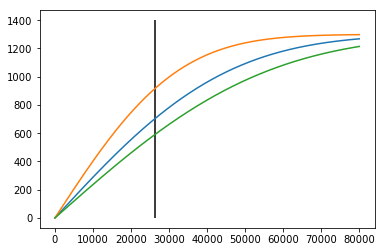

In [72]:
fig, ax = plt.subplots()
ax.plot(zs,TsZRef )
ax.plot(zs,TsZYoung )
ax.plot(zs,TsZOld )
ax.vlines(d70, 0, 1400.)

## Estimates of strain rate, elastic stresses etc

In [ ]:
#get typical values for strain rate etc
blok = -150
#dimCurvature = y3[blok:-blok].min()*(1./2900e3**2)

dimCurvature =  cx_F1[:blok].min()*(1./2900e3**2)

#dimCurvature = c[blok:-blok].min()*(1./2900e3**2)

rocEst = np.sqrt(1./abs(dimCurvature))
ypos = 15e3
refBendStrainRate = abs(dimCurvature*(5*u.centimeter/u.year).to_base_units()*ypos).magnitude
effVisc  = 200e6/(2*refBendStrainRate)
slabPullStress = 200e6 
stretchRateAtEffVisc = slabPullStress/(2.*effVisc ) 

dimCurvature, rocEst, refBendStrainRate, effVisc, stretchRateAtEffVisc
#kostrov strain rate,
#if all strain was released seismogenically by Peubla-sized events, 
#what is the recurrence interval per eqVolume
#http://ds.iris.edu/spud/momenttensor/14300411
#eq rupture volume based on: "Bend Faulting at the Edge of a Flat Slab: The 2017 Mw7.1 Puebla-Morelos, Mexico Earthquake"

rigidity = 3e11 #dyne-cm 
scalarMom = 6.391e26
volumeOfEq = 100*30e3*100*30e3*100*60e3 #in centimetres to match dyne-cm convention
eqStrain = scalarMom/(2*rigidity*volumeOfEq)
eqRecurrence = ((eqStrain/refBendStrainRate)*u.seconds).to(u.years)

rocEst2 = 200e3
E =  60e9 #basalt
poisson = 0.25
Ep = E/(1. - poisson**2)
y = np.linspace(0, 30e3, 100)
sigElast = Ep*y/rocEst2

fig, ax = plt.subplots()
ax.plot(y/1000., sigElast/1e9)
ax.hlines(200e6/1e9, 0, 30)

ax.set_ylabel('Stess GPa')
ax.set_xlabel('distance from slab middle line, kms')

fig, ax = plt.subplots()
ax.plot(y/1000., 100*y/rocEst2)

ax.set_ylabel('finite strain, perecent')
ax.set_xlabel('distance from slab middle line, kms')


KsEst = 1./100e3**2 #characteristic curvature gradient
yEst= 15e3          #distance from midplae
yieldStess = 200e6
ds = yieldStess/(Ep*yEst*KsEst) #distance over which plastic limit is reached
ds

## Simulating flat slab rollback 

In [84]:
dimIntDataScaled = dimIntDataScaled[::NP]
dimIntDataScaled = dimIntData.copy()
mask = (dimIntDataScaled[:,0] -  trenchLoc) > 280.
dimIntDataScaled[mask,0] = dimIntDataScaled[mask,0].min() +  (dimIntDataScaled[mask,0] - dimIntDataScaled[mask,0].min()) * 0.5

In [95]:
Wn1 = 0.03 #

B1, A1 = signal.butter(N, Wn1, output='ba')

In [96]:
fy = CubicSpline(dimIntData[:,0]/2900., dimIntData[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntData[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntData[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
c_F = signal.filtfilt(B1,A1, c_)

dxMean = ds.min()*1

_cx_0 = np.gradient(c_, dxMean)
_cx_F= signal.filtfilt(B1,A1, _cx_0)
_cx_F1= signal.filtfilt(B1,A1, _cx_0)

fy = CubicSpline(dimIntDataScaled[:,0]/2900., dimIntDataScaled[:,1]/2900.)
y1_ = fy.derivative(1)(dimIntDataScaled[:,0]/2900.)
y2_ = fy.derivative(2)(dimIntDataScaled[:,0]/2900.)
c_ = (y2_) / np.power(1 + y1_** 2, 1.5)

#c_F = gaussian_filter(c_, 5)
_c_F = signal.filtfilt(B1,A1, c_)

dxMean = ds.min()*1


__cx_0 = np.gradient(_c_F, dxMean)
__cx_F= signal.filtfilt(B1,A1, __cx_0)
__cx_F1= signal.filtfilt(B1,A1, __cx_0)

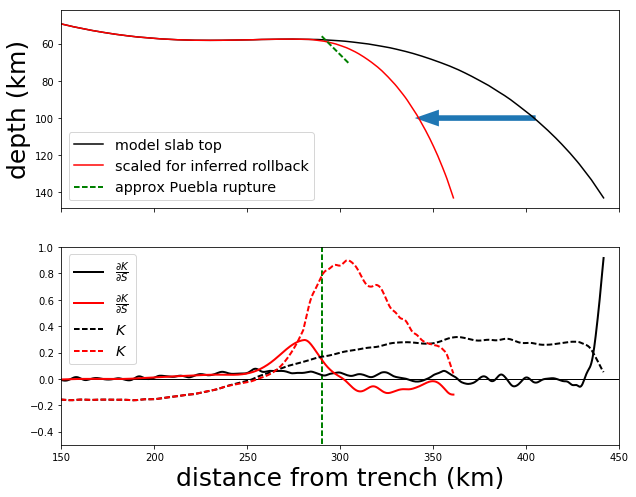

In [97]:
import matplotlib.patches as patches

#fig, ax = plt.subplots(figsize=(20,5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,8))
ax1.plot(dimIntData[:,0] - trenchLoc, dimIntData[:,1], c = 'k', label = 'model slab top')
ax1.plot(dimIntDataScaled[:,0] - trenchLoc, dimIntDataScaled[:,1],
         c = 'r', label = 'scaled for inferred rollback')


#ax.vlines(-0.1890954*2900., 0., 140)
ax1.set_ylim(160, 30)
ax1.set_xlim(150, 450)
ax1.set_aspect('equal')
#-0.1890954

ax1.add_patch(
    patches.Arrow(
        405,            # x
        100,            # y
        -65,            # dx
        0,            # dy
        width=15      # optional - defaults to 1.0
    )
)


ax1.plot([290,305], [56,71], lw = 2, c='g', ls = '--', label = 'approx Puebla rupture')
ax1.legend(fontsize = 'x-large', loc = 3)

ax1.set_ylabel('depth (km)', size = 25)
trenchLoc = -510.

ax2.plot(dimIntData[::1,0] - trenchLoc, (_cx_F1*(1./2900e3**2))/5e-10, 
        c = 'k', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')
ax2.plot(dimIntDataScaled[::1,0] - trenchLoc, (__cx_F1*(1./2900e3**2))/5e-10, 
       c = 'r', lw = 2,  label = r'$\frac{\partial{K}}{\partial{S}}$ ')

ax2.plot(dimIntData[::1,0] - trenchLoc, (c_F*(1./2900e3))/20e-6, c = 'k', 
        lw = 2,ls = '--',  label = r'$K$')
ax2.plot(dimIntDataScaled[::1,0] - trenchLoc, (_c_F*(1./2900e3))/20e-6, c = 'r',
        lw = 2,ls = '--', label = r'$K$')

ax2.legend(loc = 2, fontsize = 'x-large')
ax2.hlines(0, -200, 560, lw=1)
ax2.vlines(290, -1.1, 1.1, lw=2, colors='g', linestyles='--')

ax2.set_ylim(-0.5, 1)
#ax2.set_xlim(-200, 450)

ax2.set_xlabel('distance from trench (km)',  size = 25)

In [ ]:
#(1./np.abs((c_F*(1./2900e3)))).min(), (1./np.abs((_c_F*(1./2900e3)))).min()

## old

In [ ]:
#np.arange(8, 56,8)

times = [3.8, 7.7, 12.5, 17.3, 22.2, 30.1]

# Four axes, returned as a 2-d array
#f, axarr = plt.subplots(3, 2)
#f.tight_layout()
f = plt.figure(figsize = (7.25,6))
gs1 = gridspec.GridSpec(3, 2)
gs1.update(wspace=0.05, hspace=0.025)


count = 0
for i in np.arange(8, 56,8):
    tfile = tempFiles[i]
    tempField.load(tfile)
    tempdata = tempField.evaluate(coords[:, :])[:,0]
    #build array to collect the data
    temp = np.zeros(xv.shape) 
    temp[:] = np.flipud(tempdata.reshape((xv.shape)))*1400.0
    
    ax = plt.subplot(gs1[count])
    #plt.subplot(gs1[i])

    
    ax.contourf(temp, cmap='coolwarm', vmax = 1400, vmin = 0, 
          extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], alpha = 0.5, 
               levels = [    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1420.])

    ax.contour(temp, colors='k', levels=[650., 1250.], 
                     extent=[mesh.minCoord[0]*2900, mesh.maxCoord[0]*2900, 0, 1000], linewidths = 0.5 )

    ax.hlines(660, -1000, 1000,  alpha = 0.5 , linewidths = 1 )

    ax.set_xlim(-800, 800)
    ax.set_ylim(800, 0)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #print(count)
    ax.text(-750, 770,'{} Ma'.format(times[count]), size = 10)
    count += 1


